In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
plt.rc('axes', labelsize=14)
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

In [3]:
# If the number of responses is less than the number of
# requests that were sent then need to pad the data with
# infinite response times.
def pad_resp_df(resp_df, req_df):
    for m in req_df['mean_arrival_time'].unique():
        # extract all data for this load
        req_load_df = req_df[req_df['mean_arrival_time'] == m]
        resp_load_df = resp_df[resp_df['mean_arrival_time'] == m]
        # add dummy rows with infinite resp time if needed
        if len(resp_load_df) < len(req_load_df):
            dummy_row = resp_load_df.head(1).copy()
            dummy_row['resp_time'] = 1e100
            dummy_rows = pd.concat([dummy_row]*(len(req_load_df) - len(resp_load_df)), ignore_index=True)
            resp_df = pd.concat([resp_df, dummy_rows], ignore_index=True)
        elif len(resp_load_df) > len(req_load_df):
            print("WARNING: more responses ({}) received than requests sent ({})! m={}".format(len(resp_load_df), len(req_load_df), m))
    return resp_df

In [4]:
# The target load is different from the actual load.
# So we need to compute the actual load by looking at the request data.
def get_load_map(req_df):
    # create a dict that maps {mean_arrival_time ==> load}
    load_map = {}
    for m in req_df['mean_arrival_time'].unique():
        load_data = req_df[req_df['mean_arrival_time'] == m]
        mean_arrival_time = load_data['sent_time'].diff().mean()
        load_map[m] = 1e3/(mean_arrival_time/3.2) # MRPS
    return load_map

In [5]:
link_latency = 140
def process_resp_time(resp_df, req_df):
    # compute load
    load_map = get_load_map(req_df)
    resp_df['load'] = resp_df[['mean_arrival_time']].applymap(lambda x: load_map[x])
    # subtract the link latency
    resp_df['resp_time'] -= link_latency
    # convert resp_time from cycles to us
    resp_df['resp_time'] /= 3.2e3
    # compute and return tail latency
    resp_df = pad_resp_df(resp_df, req_df)
    tail = resp_df.groupby('load')['resp_time'].quantile(0.99)
    return tail

In [6]:
def get_zero_load_stats(resp_df, time_type='resp_time'):
    min_load = sorted(resp_df['mean_arrival_time'].unique())[-2]
    min_load_resp_df = resp_df[resp_df['mean_arrival_time'] == min_load]
    mean_arrival_time = min_load_resp_df['sent_time'].diff().mean()
    mrps = 1e3/(mean_arrival_time/3.2)
    return dict(mean_lat=min_load_resp_df[time_type].mean(),
                 p99_lat=min_load_resp_df[time_type].quantile(0.99),
                 mrps=1e3/(mean_arrival_time/3.2))
    #print min(resp_df['mean_arrival_time'].unique())

In [7]:
resdir = 'results-workload/2021-03-25--20-56-16-lnic-multi-core-mica/switch0'

lnic_mica_stats = pd.read_csv(os.path.join(resdir, 'resp_time.csv'))
lnic_mica_req_stats = pd.read_csv(os.path.join(resdir, 'req_stats.csv'))
lnic_mica_tail = process_resp_time(lnic_mica_stats, lnic_mica_req_stats)

lnic_zl_stats = get_zero_load_stats(lnic_mica_stats)
print("LNIC MICA:", lnic_zl_stats)
print(sorted(lnic_mica_stats['mean_arrival_time'].unique())[0])

LNIC MICA: {'mean_lat': 0.40423125, 'p99_lat': 0.832818749999999, 'mrps': 0.8879927114353927}
2650.0


<IPython.core.display.Javascript object>


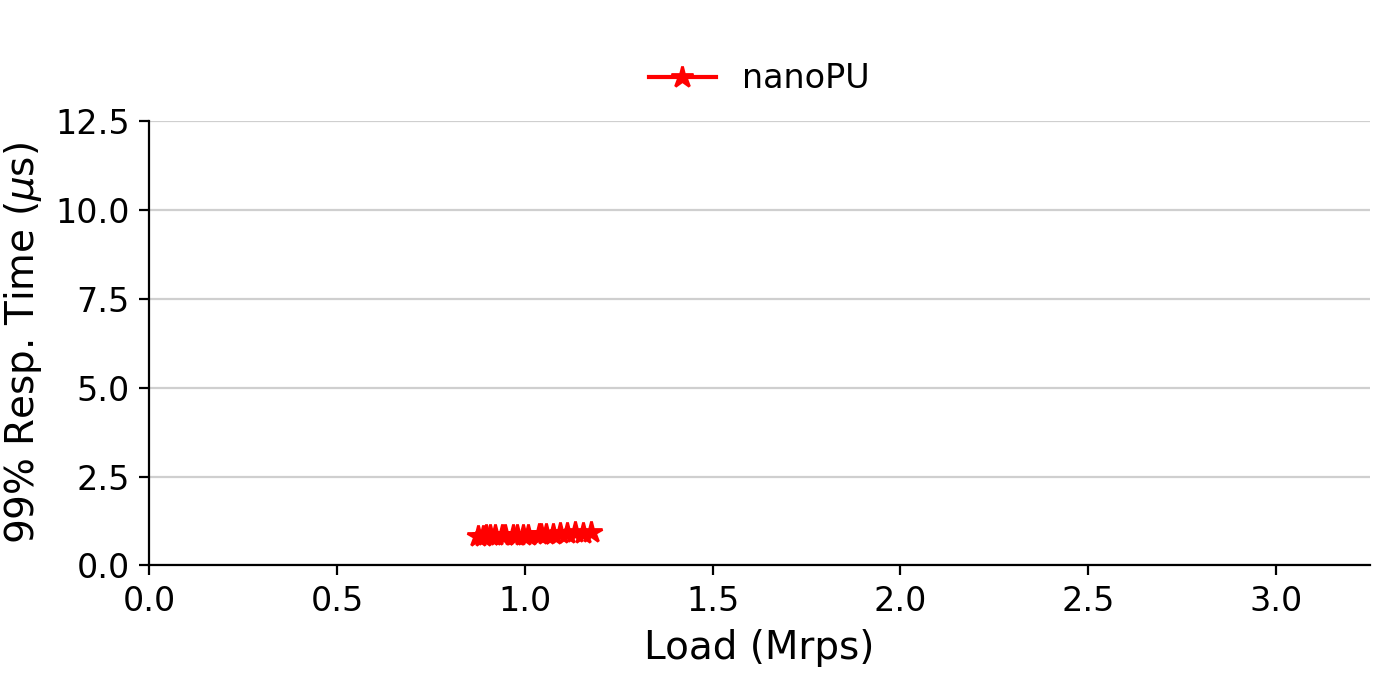

In [10]:
plt.figure(figsize=(7, 3.5))
ax = plt.gca()
# ice_mica_tail.plot(ax=ax, color='b', marker='o', markersize=8, label='Traditional')
lnic_mica_tail.plot(ax=ax, color='r', marker='*', markersize=8, label='nanoPU')
# plt.title('MICA: 99% Tail Latency vs. Load')
plt.xlabel('Load (Mrps)')
plt.ylabel('99% Resp. Time ($\mu$s)')
ax.legend(loc='upper center', frameon=False, ncol=2, bbox_to_anchor=(0.5, 1.2))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.grid(alpha=0.6)
plt.ylim([0, 12.5])
plt.xlim([0.0, 3.25])
plt.tight_layout()
plt.show()